In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from src.wrangle import read_and_filter_data
from datetime import datetime, timedelta

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 200)

In [2]:
data = pd.read_csv('city_payroll_data.csv', engine='pyarrow')

In [3]:
conditions = (
    (data['Agency Name'] == 'DEPT OF ED PEDAGOGICAL') &
    (data['Title Description'] == 'TEACHER') &
    (data['Leave Status as of June 30']!='CEASED') &
    (data['Regular Gross Paid']>=0)&
    (data['Fiscal Year']>=2021)
)

# Drop unused columns
df = data[conditions].drop(columns=['Payroll Number', 'Agency Name', 'Work Location Borough',
                                'Title Description', 'Pay Basis', 'Regular Hours', 'OT Hours',
                                'Total OT Paid', ]).drop_duplicates().reset_index(drop=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152469 entries, 0 to 152468
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Fiscal Year                 152469 non-null  int64  
 1   Last Name                   152469 non-null  object 
 2   First Name                  152469 non-null  object 
 3   Mid Init                    152469 non-null  object 
 4   Agency Start Date           152469 non-null  object 
 5   Leave Status as of June 30  152469 non-null  object 
 6   Base Salary                 152469 non-null  float64
 7   Regular Gross Paid          152469 non-null  float64
 8   Total Other Pay             152469 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 10.5+ MB


In [5]:
df.head()

,Fiscal Year,Last Name,First Name,Mid Init,Agency Start Date,Leave Status as of June 30,Base Salary,Regular Gross Paid,Total Other Pay
0,2022,APPELMAN,BROOKE,A,10/20/2015,ACTIVE,97469.0,90693.25,1486.01
1,2022,ARCIERO,DENISE,A,08/30/2007,ACTIVE,100351.0,100350.96,4851.73
2,2022,ARCILA,MARIA,I,02/02/2022,ACTIVE,69866.0,26274.50,2801.02
3,2022,ARCINIEGAS,KARINA,B,09/06/2005,ACTIVE,109852.0,104620.70,18903.82
4,2022,ARIAS,BEATRIZ,,09/05/2002,ACTIVE,111350.0,110164.13,14478.55


In [6]:
df[df['Last Name']=='APPELMAN'].sort_values(by='Fiscal Year')

,Fiscal Year,Last Name,First Name,Mid Init,Agency Start Date,Leave Status as of June 30,Base Salary,Regular Gross Paid,Total Other Pay
43172,2021,APPELMAN,BROOKE,A,10/20/2015,ACTIVE,81358.0,74186.53,712.93
0,2022,APPELMAN,BROOKE,A,10/20/2015,ACTIVE,97469.0,90693.25,1486.01
104447,2023,APPELMAN,BROOKE,A,10/20/2015,ACTIVE,97469.0,97469.04,475.00


In [7]:
df.rename(columns={'Agency Start Date': 'Hire Date',
                'Base Salary': 'Salary'}, inplace=True)

# Cast Hire Date to datetime and add Hire Year
df['Hire Date'] = pd.to_datetime(df['Hire Date'], errors='coerce')
df = df.dropna(subset=['Hire Date'])
df['Hire Year'] = df['Hire Date'].dt.year
df['Hire Year'] = df['Hire Year'].astype('Int16')

# Calculate the number of years employed as a NYC teacher
df['Years of Employment'] = df['Fiscal Year'] - df['Hire Year']
df['Years of Employment'] = df['Years of Employment'].astype('Int16')
df['Years of Employment'] = pd.to_numeric(df['Years of Employment'], errors='coerce')
df = df.dropna(subset=['Years of Employment'])

# Employee Key
df[['Last Name', 'First Name', 'Mid Init']] = df[['Last Name', 'First Name', 'Mid Init']].apply(
    lambda x: x.str.strip().str.title().fillna('None')
)
df['FirstMidLastStart'] = df['First Name'] + df['Mid Init'] + df['Last Name'] + df['Hire Date'].astype(str)
df['Employee ID'], _ = pd.factorize(df['FirstMidLastStart'], sort=True)
df = df.drop(columns=['FirstMidLastStart', 'Last Name', 'First Name', 'Mid Init'])

df = df.sort_values(by=['Employee ID', 'Fiscal Year']).reset_index(drop=True)

# Salary changes YoY
df['Salary Delta'] = df.groupby(by=['Employee ID'])['Salary'].pct_change() * 100
df['Salary Monetary Diff'] = df.groupby(by=['Employee ID'])['Salary'].diff()

df[['Salary Delta','Salary Monetary Diff']] = (df[['Salary Delta','Salary Monetary Diff']]
                                                .fillna(0)
                                                .round(2)
                                                )

# Remove outliers
df = df[(df['Hire Year']>=1980)&
        (df['Years of Employment']<=50)&
        (df['Fiscal Year']>=2021)
        ].reset_index(drop=True)

In [8]:
df = df.drop(columns=['Leave Status as of June 30'])

In [9]:
def get_paystep(salary):
    df_schedule = pd.read_csv('salary_schedule_2021.csv', engine='pyarrow')
    for index, row in df_schedule.iterrows():
        for col in df_schedule.columns[1:]:
            if salary == row[col]:
                return row['Paystep']
    return None

In [10]:
def get_differential(salary):
    df_schedule = pd.read_csv('salary_schedule_2021.csv', engine='pyarrow')
    for index, row in df_schedule.iterrows():
        for col in df_schedule.columns[1:]:
            if salary == row[col]:
                return col
    return None

In [11]:
df['Paystep'] = df['Salary'].astype('int').apply(get_paystep)

In [12]:
df['Differential'] = df['Salary'].astype('int').apply(get_differential)

In [13]:
df.head()

,Fiscal Year,Hire Date,Salary,Regular Gross Paid,Total Other Pay,Hire Year,Years of Employment,Employee ID,Salary Delta,Salary Monetary Diff,Paystep,Differential
0,2021,2011-09-01,91941.0,89597.73,15754.28,2011,10,0,0.0,0.0,8B+L5,MA+30C6
1,2022,2011-09-01,91941.0,91941.12,26024.37,2011,11,0,0.0,0.0,8B+L5,MA+30C6
2,2021,1996-09-03,128657.0,125377.47,5995.18,1996,25,1,0.0,0.0,8B+L22,MA+30C6+PD
3,2022,1996-09-03,128657.0,128657.04,6449.36,1996,26,1,0.0,0.0,8B+L22,MA+30C6+PD
4,2023,1996-09-03,128657.0,128657.04,475.00,1996,27,1,0.0,0.0,8B+L22,MA+30C6+PD


In [15]:
df = df[['Fiscal Year',
 'Employee ID',
 'Hire Date',
 'Hire Year',
 'Years of Employment',
 'Paystep',
 'Differential',
 'Salary',
 'Salary Delta',
 'Salary Monetary Diff',
 ]]

In [16]:
df['Paystep'].value_counts().sort_index()

Paystep
1A         4283
2A         4317
3A         4322
4A         5436
5A         5426
6A          176
6A+L5       544
6B         1192
6B+L5      3978
7A          101
7A+L5       807
7B         1071
7B+L5      4000
8A           73
8A+L5       903
8B         4012
8B+L10     9957
8B+L13     9771
8B+L15    18470
8B+L18    12596
8B+L20    11509
8B+L22    25020
8B+L5     19738
Name: count, dtype: int64

<Axes: xlabel='Differential', ylabel='Paystep'>

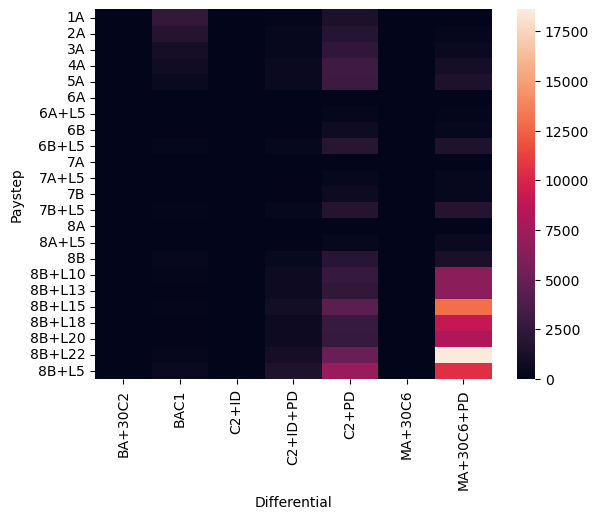

In [28]:
sns.heatmap(pd.crosstab(df['Paystep'], df['Differential']))